In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/unpaired-mr-ct-brain-dataset/JUH_MR-CT_dataset/readme.txt
/kaggle/input/unpaired-mr-ct-brain-dataset/JUH_MR-CT_dataset/MR/image_MR/3_MR_s4.dcm
/kaggle/input/unpaired-mr-ct-brain-dataset/JUH_MR-CT_dataset/MR/image_MR/12_MR_s3.dcm
/kaggle/input/unpaired-mr-ct-brain-dataset/JUH_MR-CT_dataset/MR/image_MR/18_MR_s2.dcm
/kaggle/input/unpaired-mr-ct-brain-dataset/JUH_MR-CT_dataset/MR/image_MR/3_MR_s1.dcm
/kaggle/input/unpaired-mr-ct-brain-dataset/JUH_MR-CT_dataset/MR/image_MR/9_MR_s1.dcm
/kaggle/input/unpaired-mr-ct-brain-dataset/JUH_MR-CT_dataset/MR/image_MR/16_MR_s1.dcm
/kaggle/input/unpaired-mr-ct-brain-dataset/JUH_MR-CT_dataset/MR/image_MR/9_MR_s3.dcm
/kaggle/input/unpaired-mr-ct-brain-dataset/JUH_MR-CT_dataset/MR/image_MR/9_MR_s5.dcm
/kaggle/input/unpaired-mr-ct-brain-dataset/JUH_MR-CT_dataset/MR/image_MR/17_MR_s3.dcm
/kaggle/input/unpaired-mr-ct-brain-dataset/JUH_MR-CT_dataset/MR/image_MR/15_MR_s1.dcm
/kaggle/input/unpaired-mr-ct-brain-dataset/JUH_MR-CT_dataset/MR/image_MR/

In [2]:
# %% 1) Install dependencies (if not present)
try:
    import pytorch_fid
    import lpips
    import pydicom
    import torchmetrics
    import cv2
except Exception:
    !pip install --quiet pytorch-fid lpips pydicom torchmetrics opencv-python-headless

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.3 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.5 MB/s eta 0:00:00:00:0100:01


In [3]:
import os
DATA_ROOT = '/kaggle/input/unpaired-mr-ct-brain-dataset/JUH_MR-CT_dataset'

for root, dirs, files in os.walk(DATA_ROOT):
    print(root, len(files), "files")

/kaggle/input/unpaired-mr-ct-brain-dataset/JUH_MR-CT_dataset 1 files
/kaggle/input/unpaired-mr-ct-brain-dataset/JUH_MR-CT_dataset/MR 0 files
/kaggle/input/unpaired-mr-ct-brain-dataset/JUH_MR-CT_dataset/MR/image_MR 90 files
/kaggle/input/unpaired-mr-ct-brain-dataset/JUH_MR-CT_dataset/MR/mask_MR 90 files
/kaggle/input/unpaired-mr-ct-brain-dataset/JUH_MR-CT_dataset/CT 0 files
/kaggle/input/unpaired-mr-ct-brain-dataset/JUH_MR-CT_dataset/CT/mask_CT 88 files
/kaggle/input/unpaired-mr-ct-brain-dataset/JUH_MR-CT_dataset/CT/image_CT 89 files


In [4]:
import os, glob, random, time, csv
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import cv2 # Added for Grad-CAM visualization utility

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms as T
from torchvision.utils import save_image, make_grid
from skimage.metrics import mean_squared_error, normalized_root_mse
import torch.nn.functional as F

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

# FID & LPIPS
from pytorch_fid.fid_score import calculate_fid_given_paths
import lpips
import pydicom

2025-10-19 13:38:00.154949: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760881080.375209      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760881080.441234      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loss_lpips = lpips.LPIPS(net='alex').to(device)

def calculate_mse_rmse(img1, img2):
    """Calculates MSE and RMSE for normalized numpy images [0, 1]."""
    # Convert from torch tensor [-1, 1] to numpy [0, 1]
    img1_np = ((img1.squeeze().cpu().numpy().transpose(1, 2, 0) + 1) / 2).mean(axis=2)
    img2_np = ((img2.squeeze().cpu().numpy().transpose(1, 2, 0) + 1) / 2).mean(axis=2)
    
    mse = mean_squared_error(img1_np, img2_np)
    rmse = np.sqrt(mse)
    return mse, rmse

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 215MB/s] 


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth


In [6]:
# Average meter class for logging
class AverageMeter:
    def __init__(self): self.reset()
    def reset(self): self.val=self.sum=self.count=self.avg=0.0
    def update(self, val, n=1):
        self.val=float(val); self.sum+=float(val)*n; self.count+=n; self.avg=self.sum/self.count

In [7]:
# Reproducibility
seed = 42
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda


In [8]:
# --- Hyperparams (mostly from your notebook) ---
DATA_ROOT = '/kaggle/input/unpaired-mr-ct-brain-dataset/JUH_MR-CT_dataset'
IMAGE_SIZE = 256
BATCH_SIZE = 4
NUM_WORKERS = 2
N_EPOCHS = 100
LR = 2e-4
BETA1, BETA2 = 0.5, 0.999
POOL_SIZE = 50
LAMBDA_CYCLE = 10.0
LAMBDA_IDENTITY = 5.0
LAMBDA_Z = 1.0       
SAVE_EVERY = 5

# latent dims
Z_DIM = 8       # latent vector dimension
Z_MAP_CHANNELS = 1     # we turn z -> 1-channel spatial map to concat

OUT_DIR = '/kaggle/working/cyclegan_outputs_augmented'
os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(os.path.join(OUT_DIR, 'checkpoints'), exist_ok=True)
os.makedirs(os.path.join(OUT_DIR, 'samples'), exist_ok=True)

# dataset folders
MR_FOLDER = os.path.join(DATA_ROOT, 'MR', 'image_MR')
CT_FOLDER = os.path.join(DATA_ROOT, 'CT', 'image_CT')
print('MR_FOLDER =', MR_FOLDER)
print('CT_FOLDER =', CT_FOLDER)

# sanity checks
assert os.path.isdir(MR_FOLDER), f"MR folder not found: {MR_FOLDER}"
assert os.path.isdir(CT_FOLDER), f"CT folder not found: {CT_FOLDER}"

writer = SummaryWriter(log_dir=os.path.join(OUT_DIR, 'logs'))

metrics_csv = os.path.join(OUT_DIR, 'metrics.csv')
with open(metrics_csv, 'w', newline='') as f:
    writer_csv = csv.writer(f)
    writer_csv.writerow(['epoch','iteration','loss_G','loss_D_A','loss_D_B',
                         'loss_id_A','loss_id_B','loss_gan_A2B','loss_gan_B2A',
                         'loss_cycle_A','loss_cycle_B','loss_z','lr','fid','lpips','psnr','ssim',
                         'rmse', 'mse'])

MR_FOLDER = /kaggle/input/unpaired-mr-ct-brain-dataset/JUH_MR-CT_dataset/MR/image_MR
CT_FOLDER = /kaggle/input/unpaired-mr-ct-brain-dataset/JUH_MR-CT_dataset/CT/image_CT


In [9]:
# ---------- Utility: DICOM -> PIL ----------
def dcm_to_pil(dcm_path):
    dcm = pydicom.dcmread(dcm_path)
    arr = dcm.pixel_array.astype(np.float32)
    if np.max(arr)==np.min(arr): arr=np.zeros_like(arr)
    else: arr=(arr-np.min(arr))/(np.max(arr)-np.min(arr))
    arr=(arr*255.0).astype(np.uint8)
    if arr.ndim==2: arr=np.stack([arr,arr,arr],axis=-1)
    return Image.fromarray(arr)

class UnpairedDICOMDataset(Dataset):
    def __init__(self, dir_A, dir_B, transform=None):
        self.A_paths=sorted([os.path.join(dir_A,f) for f in os.listdir(dir_A) if f.lower().endswith('.dcm')])
        self.B_paths=sorted([os.path.join(dir_B,f) for f in os.listdir(dir_B) if f.lower().endswith('.dcm')])
        if len(self.A_paths)==0: raise RuntimeError(f'No DICOM in {dir_A}')
        if len(self.B_paths)==0: raise RuntimeError(f'No DICOM in {dir_B}')
        self.transform=transform
    def __len__(self): return max(len(self.A_paths),len(self.B_paths))
    def __getitem__(self,idx):
        A_path=self.A_paths[idx%len(self.A_paths)]
        B_path=random.choice(self.B_paths)
        A_img,B_img=dcm_to_pil(A_path),dcm_to_pil(B_path)
        if self.transform:
            A=self.transform(A_img); B=self.transform(B_img)
        else:
            A=T.ToTensor()(A_img); B=T.ToTensor()(B_img)
        return {'A':A,'B':B,'A_paths':A_path,'B_paths':B_path}

transform=T.Compose([
    T.Resize((IMAGE_SIZE,IMAGE_SIZE)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
])
dataset=UnpairedDICOMDataset(MR_FOLDER,CT_FOLDER,transform=transform)
dataloader=DataLoader(dataset,batch_size=BATCH_SIZE,shuffle=True,num_workers=NUM_WORKERS,pin_memory=True,drop_last=True)
print('Dataset size =',len(dataset))

Dataset size = 90


In [10]:
# %% 6) Models (ResNet generator + PatchGAN) - modified generator input to accept z_map
class ResnetBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        block = []
        block += [nn.ReflectionPad2d(1), nn.Conv2d(dim, dim, kernel_size=3, bias=False), nn.InstanceNorm2d(dim), nn.ReLU(True)]
        block += [nn.ReflectionPad2d(1), nn.Conv2d(dim, dim, kernel_size=3, bias=False), nn.InstanceNorm2d(dim)]
        self.block = nn.Sequential(*block)

    def forward(self, x):
        return x + self.block(x)

class ResnetGenerator(nn.Module):
    """
    Generator expecting input_nc channels (3 + z_map_channels) and producing 3-channel output.
    """
    def __init__(self, input_nc, output_nc, ngf=64, n_blocks=6):
        super().__init__()
        model = []
        model += [nn.ReflectionPad2d(3), nn.Conv2d(input_nc, ngf, kernel_size=7, bias=False), nn.InstanceNorm2d(ngf), nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2 ** i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1, bias=False),
                      nn.InstanceNorm2d(ngf * mult * 2), nn.ReLU(True)]

        mult = 2 ** n_downsampling
        for i in range(n_blocks):
            model += [ResnetBlock(ngf * mult)]

        for i in range(n_downsampling):
            mult = 2 ** (n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2), kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
                      nn.InstanceNorm2d(int(ngf * mult / 2)), nn.ReLU(True)]

        model += [nn.ReflectionPad2d(3), nn.Conv2d(ngf, output_nc, kernel_size=7), nn.Tanh()]
        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

class NLayerDiscriminator(nn.Module):
    def __init__(self, input_nc, ndf=64, n_layers=3):
        super().__init__()
        kw = 4
        padw = 1
        sequence = [nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw), nn.LeakyReLU(0.2, True)]

        nf_mult = 1
        for n in range(1, n_layers):
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=2, padding=padw, bias=False),
                nn.InstanceNorm2d(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=1, padding=padw, bias=False),
            nn.InstanceNorm2d(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]
        self.model = nn.Sequential(*sequence)

    def forward(self, x):
        return self.model(x)

def init_weights(net, init_type='normal', init_gain=0.02):
    def init_fun(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                nn.init.normal_(m.weight.data, 0.0, init_gain)
            elif init_type == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=init_gain)
            elif init_type == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1 or classname.find('InstanceNorm2d') != -1:
            try:
                nn.init.normal_(m.weight.data, 1.0, init_gain)
                nn.init.constant_(m.bias.data, 0.0)
            except Exception:
                pass
    net.apply(init_fun)

In [11]:
# ---------- Latent Encoder ----------
class LatentEncoder(nn.Module):
    """Encode images to a latent vector z (Z_DIM)."""
    def __init__(self, input_nc=3, z_dim=Z_DIM, ndf=64):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_nc, ndf, 4, 2, 1), nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf, ndf*2, 4, 2, 1), nn.InstanceNorm2d(ndf*2), nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1), nn.InstanceNorm2d(ndf*4), nn.LeakyReLU(0.2, True),
        )
        # global pooling to vector
        self.fc = nn.Sequential(nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Linear(ndf*4, z_dim))

    def forward(self, x):
        f = self.conv(x)
        z = self.fc(f)
        return z

In [12]:
# ---------- Instantiate networks ----------
# Generators now expect 3 + Z_MAP_CHANNELS input channels
netG_A2B = ResnetGenerator(3 + Z_MAP_CHANNELS, 3, ngf=64, n_blocks=6).to(device)
netG_B2A = ResnetGenerator(3 + Z_MAP_CHANNELS, 3, ngf=64, n_blocks=6).to(device)
netD_A = NLayerDiscriminator(3).to(device)
netD_B = NLayerDiscriminator(3).to(device)
netE = LatentEncoder(input_nc=3, z_dim=Z_DIM).to(device)  # encoder

init_weights(netG_A2B)
init_weights(netG_B2A)
init_weights(netD_A)
init_weights(netD_B)
init_weights(netE)
# ---------- Losses, optimizers, schedulers, pools ----------
criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()
criterion_z = nn.L1Loss()  # for latent reconstruction

optimizer_G = optim.Adam(list(netG_A2B.parameters()) + list(netG_B2A.parameters()), lr=LR, betas=(BETA1, BETA2))
optimizer_D_A = optim.Adam(netD_A.parameters(), lr=LR, betas=(BETA1, BETA2))
optimizer_D_B = optim.Adam(netD_B.parameters(), lr=LR, betas=(BETA1, BETA2))
optimizer_E = optim.Adam(netE.parameters(), lr=LR, betas=(BETA1, BETA2))

def lambda_rule(epoch):
    start_decay_epoch = int(N_EPOCHS / 2)
    if epoch < start_decay_epoch:
        return 1.0
    return 1.0 - float(epoch - start_decay_epoch) / (N_EPOCHS - start_decay_epoch + 1)

scheduler_G = optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=lambda_rule)
scheduler_D_A = optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=lambda_rule)
scheduler_D_B = optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=lambda_rule)
scheduler_E = optim.lr_scheduler.LambdaLR(optimizer_E, lr_lambda=lambda_rule)

class ImagePool:
    def __init__(self, pool_size=50):
        self.pool_size = pool_size
        if pool_size > 0:
            self.images = []
            self.num_imgs = 0

    def query(self, images):
        if self.pool_size == 0:
            return images
        return_images = []
        for image in images:
            image = torch.unsqueeze(image.data, 0)
            if self.num_imgs < self.pool_size:
                self.num_imgs += 1
                self.images.append(image.clone())
                return_images.append(image)
            else:
                if random.random() > 0.5:
                    idx = random.randint(0, self.pool_size - 1)
                    tmp = self.images[idx].clone()
                    self.images[idx] = image.clone()
                    return_images.append(tmp)
                else:
                    return_images.append(image)
        return torch.cat(return_images, 0)

fake_A_pool = ImagePool(POOL_SIZE)
fake_B_pool = ImagePool(POOL_SIZE)

def make_target(pred, target_is_real=True):
    return torch.ones_like(pred, device=pred.device) if target_is_real else torch.zeros_like(pred, device=pred.device)

def get_lr(optimizer):
    return optimizer.param_groups[0]['lr']

In [13]:
# DiffAugment 
def diff_augment(x, policy='color,translation,cutout'):
    # x in [-1,1], return same shape
    out = (x + 1) / 2.0  # to [0,1]
    B, C, H, W = out.shape
    if 'color' in policy:
        b = (torch.rand(B, 1, 1, 1, device=out.device) * 0.2) + 0.9
        c = (torch.rand(B, 1, 1, 1, device=out.device) * 0.2) + 0.9
        out = out * c + (b - 1.0)
        out = out.clamp(0, 1)
    if 'translation' in policy:
        max_shift = int(0.125 * H)
        if max_shift > 0:
            shift_x = torch.randint(-max_shift, max_shift+1, (B,), device=out.device)
            shift_y = torch.randint(-max_shift, max_shift+1, (B,), device=out.device)
            res = torch.zeros_like(out)
            for i in range(B):
                sx = shift_x[i].item(); sy = shift_y[i].item()
                src = out[i]
                dst = res[i]
                x1 = max(0, sx); x2 = min(W, W+sx)
                y1 = max(0, sy); y2 = min(H, H+sy)
                sx1 = max(0, -sx); sx2 = sx1 + (x2-x1)
                sy1 = max(0, -sy); sy2 = sy1 + (y2-y1)
                dst[:, y1:y2, x1:x2] = src[:, sy1:sy2, sx1:sx2]
            out = res
    if 'cutout' in policy:
        cut_w = int(0.2*W); cut_h = int(0.2*H)
        for i in range(B):
            cx = random.randint(0, W)
            cy = random.randint(0, H)
            x1 = max(0, cx - cut_w//2); x2 = min(W, cx + cut_w//2)
            y1 = max(0, cy - cut_h//2); y2 = min(H, cy + cut_h//2)
            out[i, :, y1:y2, x1:x2] = 0.5
    return out * 2.0 - 1.0

In [14]:
# ---------- Helpers ----------
def sample_z_map(batch_size, z_dim, H, W, device):
    # sample z ~ N(0,1) and produce 1-channel spatial map by averaging dims
    z = torch.randn(batch_size, z_dim, device=device)
    z_mean = z.mean(dim=1, keepdim=True)  # (B,1)
    z_map = z_mean.view(batch_size, 1, 1, 1).expand(batch_size, 1, H, W)
    return z, z_map

print('Starting training with augmented CycleGAN...')

iteration = 0
# Meters to smooth values for printing
meter_G = AverageMeter()
meter_D_A = AverageMeter()
meter_D_B = AverageMeter()
meter_id_A = AverageMeter()
meter_id_B = AverageMeter()
meter_gan_A2B = AverageMeter()
meter_gan_B2A = AverageMeter()
meter_cycle_A = AverageMeter()
meter_cycle_B = AverageMeter()
meter_z = AverageMeter()

for epoch in range(1,N_EPOCHS+1):
    t0=time.time()
    netG_A2B.train(); netG_B2A.train(); netD_A.train(); netD_B.train(); netE.train()
    loop=tqdm(enumerate(dataloader),total=len(dataloader),desc=f"Epoch {epoch}/{N_EPOCHS}")
    for i,data in loop:
        real_A,real_B=data['A'].to(device),data['B'].to(device)

        # ---- Train Generators + Encoder ----
        optimizer_G.zero_grad()
        optimizer_E.zero_grad()

        # Sample random z's for augmentation (per sample)
        B_size = real_A.size(0)
        _, _, H, W = real_A.shape
        z_A, z_map_A = sample_z_map(B_size, Z_DIM, H, W, device)
        z_B, z_map_B = sample_z_map(B_size, Z_DIM, H, W, device)

        # identity (apply generator to real of same domain with z from that image)
        same_B = netG_A2B(torch.cat([real_B, z_map_B], dim=1))
        loss_id_B = criterion_identity(same_B, real_B) * LAMBDA_IDENTITY
        same_A = netG_B2A(torch.cat([real_A, z_map_A], dim=1))
        loss_id_A = criterion_identity(same_A, real_A) * LAMBDA_IDENTITY

        # GAN forward (A->B) and (B->A)
        fake_B = netG_A2B(torch.cat([real_A, z_map_A], dim=1))
        pred_fake_B = netD_B(diff_augment(fake_B))  # apply diffaugment before D
        loss_GAN_A2B = criterion_GAN(pred_fake_B, make_target(pred_fake_B, True))

        fake_A = netG_B2A(torch.cat([real_B, z_map_B], dim=1))
        pred_fake_A = netD_A(diff_augment(fake_A))
        loss_GAN_B2A = criterion_GAN(pred_fake_A, make_target(pred_fake_A, True))

        # cycle: reconstruct A from fake_B and B from fake_A
        # For cycle we sample new z's (paper sometimes encodes, here we resample to encourage stochasticity),
        z_A2, z_map_A2 = sample_z_map(B_size, Z_DIM, H, W, device)
        z_B2, z_map_B2 = sample_z_map(B_size, Z_DIM, H, W, device)
        rec_A = netG_B2A(torch.cat([fake_B, z_map_A2], dim=1))
        loss_cycle_A = criterion_cycle(rec_A, real_A) * LAMBDA_CYCLE
        rec_B = netG_A2B(torch.cat([fake_A, z_map_B2], dim=1))
        loss_cycle_B = criterion_cycle(rec_B, real_B) * LAMBDA_CYCLE

        # latent reconstruction: E should recover the sampled z from generated images
        z_rec_from_fakeB = netE(fake_B)  # should approximate z_A
        z_rec_from_fakeA = netE(fake_A)  # should approximate z_B
        loss_z = (criterion_z(z_rec_from_fakeB, z_A) + criterion_z(z_rec_from_fakeA, z_B)) * LAMBDA_Z

        # total generator loss
        loss_G = loss_id_A + loss_id_B + loss_GAN_A2B + loss_GAN_B2A + loss_cycle_A + loss_cycle_B + loss_z
        loss_G.backward()
        optimizer_G.step()
        optimizer_E.step()

        # ---- Train Discriminator A ----
        optimizer_D_A.zero_grad()
        pred_real_A = netD_A(diff_augment(real_A))
        loss_D_real_A = criterion_GAN(pred_real_A, make_target(pred_real_A, True))

        fake_A_det = fake_A_pool.query(fake_A.detach())
        pred_fake_A = netD_A(diff_augment(fake_A_det))
        loss_D_fake_A = criterion_GAN(pred_fake_A, make_target(pred_fake_A, False))

        loss_D_A = (loss_D_real_A + loss_D_fake_A) * 0.5
        loss_D_A.backward()
        optimizer_D_A.step()

        # ---- Train Discriminator B ----
        optimizer_D_B.zero_grad()
        pred_real_B = netD_B(diff_augment(real_B))
        loss_D_real_B = criterion_GAN(pred_real_B, make_target(pred_real_B, True))

        fake_B_det = fake_B_pool.query(fake_B.detach())
        pred_fake_B = netD_B(diff_augment(fake_B_det))
        loss_D_fake_B = criterion_GAN(pred_fake_B, make_target(pred_fake_B, False))

        loss_D_B = (loss_D_real_B + loss_D_fake_B) * 0.5
        loss_D_B.backward()
        optimizer_D_B.step()

        # update iteration counters and meters
        iteration += 1
        meter_G.update(loss_G.item())
        meter_D_A.update(loss_D_A.item())
        meter_D_B.update(loss_D_B.item())
        meter_id_A.update(loss_id_A.item())
        meter_id_B.update(loss_id_B.item())
        meter_gan_A2B.update(loss_GAN_A2B.item())
        meter_gan_B2A.update(loss_GAN_B2A.item())
        meter_cycle_A.update(loss_cycle_A.item())
        meter_cycle_B.update(loss_cycle_B.item())
        meter_z.update(loss_z.item())

        # TensorBoard per-iteration logging (sample every 50 iters)
        if iteration % 50 == 0:
            writer.add_scalar('Loss/loss_G', meter_G.avg, iteration)
            writer.add_scalar('Loss/loss_D_A', meter_D_A.avg, iteration)
            writer.add_scalar('Loss/loss_D_B', meter_D_B.avg, iteration)
            writer.add_scalar('Loss/loss_z', meter_z.avg, iteration)
            writer.add_scalar('LR/lr_G', get_lr(optimizer_G), iteration)

        if iteration%500==0:
            with torch.no_grad():
                sample=torch.cat([real_A[:2],fake_B[:2],real_B[:2],fake_A[:2]],0)
                sample_img=(sample+1)/2.0
                grid_img=make_grid(sample_img,nrow=2,padding=2,normalize=False)
                save_image(sample_img,os.path.join(OUT_DIR,'samples',f'iter_{iteration}.png'),nrow=2)
                writer.add_image('Samples/iter',grid_img,iteration)

        # update tqdm display
        loop.set_postfix({
            'G': f'{meter_G.avg:.4f}',
            'D_A': f'{meter_D_A.avg:.4f}',
            'D_B': f'{meter_D_B.avg:.4f}',
            'Z': f'{meter_z.avg:.4f}'
        })

    # end of epoch: scheduler step
    scheduler_G.step()
    scheduler_D_A.step()
    scheduler_D_B.step()
    scheduler_E.step()

    # save checkpoint every SAVE_EVERY epochs
    if epoch % SAVE_EVERY == 0 or epoch == N_EPOCHS:
        ckpt_path = os.path.join(OUT_DIR, 'checkpoints', f'ckpt_epoch_{epoch}.pth')
        torch.save({
            'epoch': epoch,
            'netG_A2B': netG_A2B.state_dict(),
            'netG_B2A': netG_B2A.state_dict(),
            'netD_A': netD_A.state_dict(),
            'netD_B': netD_B.state_dict(),
            'netE': netE.state_dict(),
            'optim_G': optimizer_G.state_dict(),
            'optim_E': optimizer_E.state_dict()
        }, ckpt_path)

    # Log epoch metrics to CSV (removed ms_ssim placeholder)
    # The FID/LPIPS/PSNR/SSIM/RMSE/MSE metrics are calculated and appended
    # in the dedicated evaluation block (%% 10) after training loop finishes.
    # For in-loop epoch logging, we will log the training losses now and defer image-based metrics.
    with open(metrics_csv, 'a', newline='') as f:
        writer_csv = csv.writer(f)
        writer_csv.writerow([
            epoch, iteration, meter_G.avg, meter_D_A.avg, meter_D_B.avg,
            meter_id_A.avg, meter_id_B.avg, meter_gan_A2B.avg, meter_gan_B2A.avg,
            meter_cycle_A.avg, meter_cycle_B.avg, meter_z.avg, get_lr(optimizer_G),
            '', '', '', '', '', '' # REMOVED: '', placeholder for ms_ssim
        ])

    # print epoch summary
    t1 = time.time()
    print(f"Epoch {epoch} finished in {t1-t0:.1f}s - G: {meter_G.avg:.4f}, D_A: {meter_D_A.avg:.4f}, D_B: {meter_D_B.avg:.4f}, Z: {meter_z.avg:.4f}")

print('Training finished.')
writer.close()

Starting training with augmented CycleGAN...


Epoch 1/100: 100%|██████████| 22/22 [00:38<00:00,  1.76s/it, G=12.3650, D_A=1.4284, D_B=1.7675, Z=1.5876]

Epoch 1 finished in 38.9s - G: 12.3650, D_A: 1.4284, D_B: 1.7675, Z: 1.5876



Epoch 2/100: 100%|██████████| 22/22 [00:40<00:00,  1.83s/it, G=8.8479, D_A=0.9819, D_B=1.1314, Z=1.5819] 

Epoch 2 finished in 40.4s - G: 8.8479, D_A: 0.9819, D_B: 1.1314, Z: 1.5819



Epoch 3/100: 100%|██████████| 22/22 [00:42<00:00,  1.94s/it, G=7.4545, D_A=0.7545, D_B=0.8793, Z=1.5880]

Epoch 3 finished in 42.7s - G: 7.4545, D_A: 0.7545, D_B: 0.8793, Z: 1.5880



Epoch 4/100: 100%|██████████| 22/22 [00:41<00:00,  1.90s/it, G=6.7615, D_A=0.6425, D_B=0.7421, Z=1.5974]

Epoch 4 finished in 41.9s - G: 6.7615, D_A: 0.6425, D_B: 0.7421, Z: 1.5974



Epoch 5/100: 100%|██████████| 22/22 [00:42<00:00,  1.92s/it, G=6.3238, D_A=0.5603, D_B=0.6523, Z=1.6001]


Epoch 5 finished in 42.5s - G: 6.3238, D_A: 0.5603, D_B: 0.6523, Z: 1.6001


Epoch 6/100: 100%|██████████| 22/22 [00:41<00:00,  1.91s/it, G=6.0102, D_A=0.5077, D_B=0.5825, Z=1.6002]

Epoch 6 finished in 42.0s - G: 6.0102, D_A: 0.5077, D_B: 0.5825, Z: 1.6002



Epoch 7/100: 100%|██████████| 22/22 [00:42<00:00,  1.91s/it, G=5.8241, D_A=0.4715, D_B=0.5445, Z=1.6012]

Epoch 7 finished in 42.1s - G: 5.8241, D_A: 0.4715, D_B: 0.5445, Z: 1.6012



Epoch 8/100: 100%|██████████| 22/22 [00:42<00:00,  1.91s/it, G=5.6408, D_A=0.4403, D_B=0.5002, Z=1.6035]

Epoch 8 finished in 42.2s - G: 5.6408, D_A: 0.4403, D_B: 0.5002, Z: 1.6035



Epoch 9/100: 100%|██████████| 22/22 [00:42<00:00,  1.91s/it, G=5.5018, D_A=0.4136, D_B=0.4750, Z=1.5991]

Epoch 9 finished in 42.2s - G: 5.5018, D_A: 0.4136, D_B: 0.4750, Z: 1.5991



Epoch 10/100: 100%|██████████| 22/22 [00:41<00:00,  1.91s/it, G=5.3822, D_A=0.3962, D_B=0.4510, Z=1.6019]


Epoch 10 finished in 42.3s - G: 5.3822, D_A: 0.3962, D_B: 0.4510, Z: 1.6019


Epoch 11/100: 100%|██████████| 22/22 [00:42<00:00,  1.91s/it, G=5.2785, D_A=0.3807, D_B=0.4298, Z=1.6010]

Epoch 11 finished in 42.1s - G: 5.2785, D_A: 0.3807, D_B: 0.4298, Z: 1.6010



Epoch 12/100: 100%|██████████| 22/22 [00:42<00:00,  1.91s/it, G=5.1898, D_A=0.3693, D_B=0.4118, Z=1.5931]

Epoch 12 finished in 42.1s - G: 5.1898, D_A: 0.3693, D_B: 0.4118, Z: 1.5931



Epoch 13/100: 100%|██████████| 22/22 [00:42<00:00,  1.91s/it, G=5.1125, D_A=0.3583, D_B=0.3968, Z=1.5945]

Epoch 13 finished in 42.2s - G: 5.1125, D_A: 0.3583, D_B: 0.3968, Z: 1.5945



Epoch 14/100: 100%|██████████| 22/22 [00:42<00:00,  1.91s/it, G=5.0509, D_A=0.3524, D_B=0.3860, Z=1.5957]

Epoch 14 finished in 42.1s - G: 5.0509, D_A: 0.3524, D_B: 0.3860, Z: 1.5957



Epoch 15/100: 100%|██████████| 22/22 [00:41<00:00,  1.91s/it, G=5.0011, D_A=0.3450, D_B=0.3744, Z=1.5987]


Epoch 15 finished in 42.3s - G: 5.0011, D_A: 0.3450, D_B: 0.3744, Z: 1.5987


Epoch 16/100: 100%|██████████| 22/22 [00:42<00:00,  1.91s/it, G=4.9590, D_A=0.3359, D_B=0.3656, Z=1.5998]

Epoch 16 finished in 42.1s - G: 4.9590, D_A: 0.3359, D_B: 0.3656, Z: 1.5998



Epoch 17/100: 100%|██████████| 22/22 [00:42<00:00,  1.91s/it, G=4.9141, D_A=0.3298, D_B=0.3582, Z=1.6008]

Epoch 17 finished in 42.1s - G: 4.9141, D_A: 0.3298, D_B: 0.3582, Z: 1.6008



Epoch 18/100: 100%|██████████| 22/22 [00:42<00:00,  1.91s/it, G=4.8670, D_A=0.3249, D_B=0.3496, Z=1.5975]

Epoch 18 finished in 42.1s - G: 4.8670, D_A: 0.3249, D_B: 0.3496, Z: 1.5975



Epoch 19/100: 100%|██████████| 22/22 [00:41<00:00,  1.91s/it, G=4.8227, D_A=0.3206, D_B=0.3486, Z=1.5966]

Epoch 19 finished in 42.0s - G: 4.8227, D_A: 0.3206, D_B: 0.3486, Z: 1.5966



Epoch 20/100: 100%|██████████| 22/22 [00:42<00:00,  1.91s/it, G=4.7788, D_A=0.3179, D_B=0.3440, Z=1.5976]


Epoch 20 finished in 42.4s - G: 4.7788, D_A: 0.3179, D_B: 0.3440, Z: 1.5976


Epoch 21/100: 100%|██████████| 22/22 [00:42<00:00,  1.91s/it, G=4.7343, D_A=0.3153, D_B=0.3383, Z=1.5995]

Epoch 21 finished in 42.1s - G: 4.7343, D_A: 0.3153, D_B: 0.3383, Z: 1.5995



Epoch 22/100: 100%|██████████| 22/22 [00:42<00:00,  1.91s/it, G=4.7022, D_A=0.3112, D_B=0.3328, Z=1.6006]

Epoch 22 finished in 42.1s - G: 4.7022, D_A: 0.3112, D_B: 0.3328, Z: 1.6006



Epoch 23/100: 100%|██████████| 22/22 [00:42<00:00,  1.92s/it, G=4.6654, D_A=0.3116, D_B=0.3292, Z=1.6007]

Epoch 23 finished in 42.3s - G: 4.6654, D_A: 0.3116, D_B: 0.3292, Z: 1.6007



Epoch 24/100: 100%|██████████| 22/22 [00:41<00:00,  1.91s/it, G=4.6291, D_A=0.3096, D_B=0.3258, Z=1.6000]

Epoch 24 finished in 42.0s - G: 4.6291, D_A: 0.3096, D_B: 0.3258, Z: 1.6000



Epoch 25/100: 100%|██████████| 22/22 [00:42<00:00,  1.91s/it, G=4.5905, D_A=0.3068, D_B=0.3227, Z=1.6000]


Epoch 25 finished in 42.4s - G: 4.5905, D_A: 0.3068, D_B: 0.3227, Z: 1.6000


Epoch 26/100: 100%|██████████| 22/22 [00:42<00:00,  1.91s/it, G=4.5553, D_A=0.3062, D_B=0.3206, Z=1.5996]

Epoch 26 finished in 42.1s - G: 4.5553, D_A: 0.3062, D_B: 0.3206, Z: 1.5996



Epoch 27/100: 100%|██████████| 22/22 [00:42<00:00,  1.91s/it, G=4.5331, D_A=0.3039, D_B=0.3171, Z=1.5997]

Epoch 27 finished in 42.1s - G: 4.5331, D_A: 0.3039, D_B: 0.3171, Z: 1.5997



Epoch 28/100: 100%|██████████| 22/22 [00:42<00:00,  1.91s/it, G=4.5058, D_A=0.3024, D_B=0.3156, Z=1.5988]

Epoch 28 finished in 42.1s - G: 4.5058, D_A: 0.3024, D_B: 0.3156, Z: 1.5988



Epoch 29/100: 100%|██████████| 22/22 [00:41<00:00,  1.91s/it, G=4.4781, D_A=0.3023, D_B=0.3135, Z=1.5989]

Epoch 29 finished in 42.0s - G: 4.4781, D_A: 0.3023, D_B: 0.3135, Z: 1.5989



Epoch 30/100: 100%|██████████| 22/22 [00:42<00:00,  1.91s/it, G=4.4488, D_A=0.3004, D_B=0.3122, Z=1.5991]


Epoch 30 finished in 42.3s - G: 4.4488, D_A: 0.3004, D_B: 0.3122, Z: 1.5991


Epoch 31/100: 100%|██████████| 22/22 [00:42<00:00,  1.91s/it, G=4.4222, D_A=0.2995, D_B=0.3100, Z=1.6000]

Epoch 31 finished in 42.1s - G: 4.4222, D_A: 0.2995, D_B: 0.3100, Z: 1.6000



Epoch 32/100: 100%|██████████| 22/22 [00:42<00:00,  1.91s/it, G=4.3966, D_A=0.2988, D_B=0.3084, Z=1.6008]

Epoch 32 finished in 42.1s - G: 4.3966, D_A: 0.2988, D_B: 0.3084, Z: 1.6008



Epoch 33/100: 100%|██████████| 22/22 [00:42<00:00,  1.92s/it, G=4.3717, D_A=0.2973, D_B=0.3070, Z=1.6020]

Epoch 33 finished in 42.2s - G: 4.3717, D_A: 0.2973, D_B: 0.3070, Z: 1.6020



Epoch 34/100: 100%|██████████| 22/22 [00:42<00:00,  1.91s/it, G=4.3459, D_A=0.2970, D_B=0.3055, Z=1.6019]

Epoch 34 finished in 42.1s - G: 4.3459, D_A: 0.2970, D_B: 0.3055, Z: 1.6019



Epoch 35/100: 100%|██████████| 22/22 [00:42<00:00,  1.91s/it, G=4.3244, D_A=0.2963, D_B=0.3046, Z=1.6027]


Epoch 35 finished in 42.4s - G: 4.3244, D_A: 0.2963, D_B: 0.3046, Z: 1.6027


Epoch 36/100: 100%|██████████| 22/22 [00:41<00:00,  1.91s/it, G=4.3004, D_A=0.2953, D_B=0.3036, Z=1.6018]

Epoch 36 finished in 42.0s - G: 4.3004, D_A: 0.2953, D_B: 0.3036, Z: 1.6018



Epoch 37/100: 100%|██████████| 22/22 [00:41<00:00,  1.91s/it, G=4.2802, D_A=0.2944, D_B=0.3028, Z=1.6004]

Epoch 37 finished in 42.0s - G: 4.2802, D_A: 0.2944, D_B: 0.3028, Z: 1.6004



Epoch 38/100: 100%|██████████| 22/22 [00:41<00:00,  1.91s/it, G=4.2591, D_A=0.2938, D_B=0.3015, Z=1.5990]

Epoch 38 finished in 42.0s - G: 4.2591, D_A: 0.2938, D_B: 0.3015, Z: 1.5990



Epoch 39/100: 100%|██████████| 22/22 [00:42<00:00,  1.91s/it, G=4.2381, D_A=0.2928, D_B=0.3004, Z=1.5982]

Epoch 39 finished in 42.1s - G: 4.2381, D_A: 0.2928, D_B: 0.3004, Z: 1.5982



Epoch 40/100: 100%|██████████| 22/22 [00:42<00:00,  1.91s/it, G=4.2184, D_A=0.2923, D_B=0.2995, Z=1.5976]


Epoch 40 finished in 42.4s - G: 4.2184, D_A: 0.2923, D_B: 0.2995, Z: 1.5976


Epoch 41/100: 100%|██████████| 22/22 [00:42<00:00,  1.91s/it, G=4.1985, D_A=0.2920, D_B=0.2981, Z=1.5968]

Epoch 41 finished in 42.2s - G: 4.1985, D_A: 0.2920, D_B: 0.2981, Z: 1.5968



Epoch 42/100: 100%|██████████| 22/22 [00:42<00:00,  1.91s/it, G=4.1799, D_A=0.2912, D_B=0.2970, Z=1.5970]

Epoch 42 finished in 42.2s - G: 4.1799, D_A: 0.2912, D_B: 0.2970, Z: 1.5970



Epoch 43/100: 100%|██████████| 22/22 [00:42<00:00,  1.91s/it, G=4.1717, D_A=0.2905, D_B=0.3061, Z=1.5982]

Epoch 43 finished in 42.1s - G: 4.1717, D_A: 0.2905, D_B: 0.3061, Z: 1.5982



Epoch 44/100: 100%|██████████| 22/22 [00:41<00:00,  1.91s/it, G=4.1531, D_A=0.2901, D_B=0.3049, Z=1.5989]

Epoch 44 finished in 42.0s - G: 4.1531, D_A: 0.2901, D_B: 0.3049, Z: 1.5989



Epoch 45/100: 100%|██████████| 22/22 [00:41<00:00,  1.91s/it, G=4.1473, D_A=0.2887, D_B=0.3034, Z=1.5982]


Epoch 45 finished in 42.3s - G: 4.1473, D_A: 0.2887, D_B: 0.3034, Z: 1.5982


Epoch 46/100: 100%|██████████| 22/22 [00:42<00:00,  1.92s/it, G=4.1407, D_A=0.2905, D_B=0.3015, Z=1.5992]

Epoch 46 finished in 42.3s - G: 4.1407, D_A: 0.2905, D_B: 0.3015, Z: 1.5992



Epoch 47/100: 100%|██████████| 22/22 [00:42<00:00,  1.91s/it, G=4.1276, D_A=0.2886, D_B=0.3000, Z=1.5995]

Epoch 47 finished in 42.1s - G: 4.1276, D_A: 0.2886, D_B: 0.3000, Z: 1.5995



Epoch 48/100: 100%|██████████| 22/22 [00:42<00:00,  1.91s/it, G=4.1112, D_A=0.2871, D_B=0.2985, Z=1.5990]

Epoch 48 finished in 42.1s - G: 4.1112, D_A: 0.2871, D_B: 0.2985, Z: 1.5990



Epoch 49/100: 100%|██████████| 22/22 [00:41<00:00,  1.91s/it, G=4.0976, D_A=0.2883, D_B=0.2972, Z=1.5992]

Epoch 49 finished in 42.0s - G: 4.0976, D_A: 0.2883, D_B: 0.2972, Z: 1.5992



Epoch 50/100: 100%|██████████| 22/22 [00:41<00:00,  1.91s/it, G=4.0831, D_A=0.2875, D_B=0.2958, Z=1.5989]


Epoch 50 finished in 42.3s - G: 4.0831, D_A: 0.2875, D_B: 0.2958, Z: 1.5989


Epoch 51/100: 100%|██████████| 22/22 [00:41<00:00,  1.91s/it, G=4.0684, D_A=0.2865, D_B=0.2947, Z=1.5983]

Epoch 51 finished in 42.0s - G: 4.0684, D_A: 0.2865, D_B: 0.2947, Z: 1.5983



Epoch 52/100: 100%|██████████| 22/22 [00:42<00:00,  1.92s/it, G=4.0559, D_A=0.2854, D_B=0.2937, Z=1.5993]

Epoch 52 finished in 42.2s - G: 4.0559, D_A: 0.2854, D_B: 0.2937, Z: 1.5993



Epoch 53/100: 100%|██████████| 22/22 [00:42<00:00,  1.91s/it, G=4.0432, D_A=0.2846, D_B=0.2927, Z=1.5994]

Epoch 53 finished in 42.1s - G: 4.0432, D_A: 0.2846, D_B: 0.2927, Z: 1.5994



Epoch 54/100: 100%|██████████| 22/22 [00:42<00:00,  1.91s/it, G=4.0304, D_A=0.2838, D_B=0.2918, Z=1.5994]

Epoch 54 finished in 42.1s - G: 4.0304, D_A: 0.2838, D_B: 0.2918, Z: 1.5994



Epoch 55/100: 100%|██████████| 22/22 [00:42<00:00,  1.91s/it, G=4.0158, D_A=0.2829, D_B=0.2908, Z=1.5981]


Epoch 55 finished in 42.4s - G: 4.0158, D_A: 0.2829, D_B: 0.2908, Z: 1.5981


Epoch 56/100: 100%|██████████| 22/22 [00:41<00:00,  1.91s/it, G=4.0141, D_A=0.2814, D_B=0.2897, Z=1.5981]

Epoch 56 finished in 42.0s - G: 4.0141, D_A: 0.2814, D_B: 0.2897, Z: 1.5981



Epoch 57/100: 100%|██████████| 22/22 [00:41<00:00,  1.91s/it, G=4.0069, D_A=0.2799, D_B=0.2881, Z=1.5977]

Epoch 57 finished in 42.0s - G: 4.0069, D_A: 0.2799, D_B: 0.2881, Z: 1.5977



Epoch 58/100: 100%|██████████| 22/22 [00:41<00:00,  1.91s/it, G=4.0061, D_A=0.2791, D_B=0.2869, Z=1.5974]

Epoch 58 finished in 42.0s - G: 4.0061, D_A: 0.2791, D_B: 0.2869, Z: 1.5974



Epoch 59/100: 100%|██████████| 22/22 [00:42<00:00,  1.91s/it, G=4.0139, D_A=0.2773, D_B=0.2852, Z=1.5965]

Epoch 59 finished in 42.1s - G: 4.0139, D_A: 0.2773, D_B: 0.2852, Z: 1.5965



Epoch 60/100: 100%|██████████| 22/22 [00:42<00:00,  1.91s/it, G=4.0154, D_A=0.2752, D_B=0.2837, Z=1.5956]


Epoch 60 finished in 42.4s - G: 4.0154, D_A: 0.2752, D_B: 0.2837, Z: 1.5956


Epoch 61/100: 100%|██████████| 22/22 [00:42<00:00,  1.91s/it, G=4.0152, D_A=0.2731, D_B=0.2822, Z=1.5954]

Epoch 61 finished in 42.1s - G: 4.0152, D_A: 0.2731, D_B: 0.2822, Z: 1.5954



Epoch 62/100: 100%|██████████| 22/22 [00:42<00:00,  1.91s/it, G=4.0128, D_A=0.2714, D_B=0.2811, Z=1.5952]

Epoch 62 finished in 42.1s - G: 4.0128, D_A: 0.2714, D_B: 0.2811, Z: 1.5952



Epoch 63/100: 100%|██████████| 22/22 [00:41<00:00,  1.91s/it, G=4.0085, D_A=0.2699, D_B=0.2803, Z=1.5951]

Epoch 63 finished in 42.1s - G: 4.0085, D_A: 0.2699, D_B: 0.2803, Z: 1.5951



Epoch 64/100: 100%|██████████| 22/22 [00:41<00:00,  1.91s/it, G=4.0034, D_A=0.2690, D_B=0.2797, Z=1.5951]

Epoch 64 finished in 42.0s - G: 4.0034, D_A: 0.2690, D_B: 0.2797, Z: 1.5951



Epoch 65/100: 100%|██████████| 22/22 [00:42<00:00,  1.91s/it, G=3.9970, D_A=0.2685, D_B=0.2789, Z=1.5951]


Epoch 65 finished in 42.4s - G: 3.9970, D_A: 0.2685, D_B: 0.2789, Z: 1.5951


Epoch 66/100: 100%|██████████| 22/22 [00:42<00:00,  1.91s/it, G=3.9894, D_A=0.2676, D_B=0.2781, Z=1.5950]

Epoch 66 finished in 42.1s - G: 3.9894, D_A: 0.2676, D_B: 0.2781, Z: 1.5950



Epoch 67/100: 100%|██████████| 22/22 [00:42<00:00,  1.91s/it, G=3.9812, D_A=0.2665, D_B=0.2776, Z=1.5944]

Epoch 67 finished in 42.1s - G: 3.9812, D_A: 0.2665, D_B: 0.2776, Z: 1.5944



Epoch 68/100: 100%|██████████| 22/22 [00:41<00:00,  1.91s/it, G=3.9756, D_A=0.2655, D_B=0.2767, Z=1.5944]

Epoch 68 finished in 42.0s - G: 3.9756, D_A: 0.2655, D_B: 0.2767, Z: 1.5944



Epoch 69/100: 100%|██████████| 22/22 [00:42<00:00,  1.92s/it, G=3.9679, D_A=0.2646, D_B=0.2760, Z=1.5942]

Epoch 69 finished in 42.4s - G: 3.9679, D_A: 0.2646, D_B: 0.2760, Z: 1.5942



Epoch 70/100: 100%|██████████| 22/22 [00:42<00:00,  1.91s/it, G=3.9586, D_A=0.2638, D_B=0.2753, Z=1.5936]


Epoch 70 finished in 42.3s - G: 3.9586, D_A: 0.2638, D_B: 0.2753, Z: 1.5936


Epoch 71/100: 100%|██████████| 22/22 [00:42<00:00,  1.91s/it, G=3.9488, D_A=0.2632, D_B=0.2747, Z=1.5932]

Epoch 71 finished in 42.1s - G: 3.9488, D_A: 0.2632, D_B: 0.2747, Z: 1.5932



Epoch 72/100: 100%|██████████| 22/22 [00:42<00:00,  1.91s/it, G=3.9407, D_A=0.2626, D_B=0.2742, Z=1.5934]

Epoch 72 finished in 42.1s - G: 3.9407, D_A: 0.2626, D_B: 0.2742, Z: 1.5934



Epoch 73/100: 100%|██████████| 22/22 [00:42<00:00,  1.91s/it, G=3.9321, D_A=0.2621, D_B=0.2736, Z=1.5934]

Epoch 73 finished in 42.1s - G: 3.9321, D_A: 0.2621, D_B: 0.2736, Z: 1.5934



Epoch 74/100: 100%|██████████| 22/22 [00:41<00:00,  1.91s/it, G=3.9246, D_A=0.2615, D_B=0.2731, Z=1.5939]

Epoch 74 finished in 42.0s - G: 3.9246, D_A: 0.2615, D_B: 0.2731, Z: 1.5939



Epoch 75/100: 100%|██████████| 22/22 [00:41<00:00,  1.91s/it, G=3.9170, D_A=0.2609, D_B=0.2725, Z=1.5943]


Epoch 75 finished in 42.3s - G: 3.9170, D_A: 0.2609, D_B: 0.2725, Z: 1.5943


Epoch 76/100: 100%|██████████| 22/22 [00:41<00:00,  1.91s/it, G=3.9089, D_A=0.2604, D_B=0.2720, Z=1.5947]

Epoch 76 finished in 42.1s - G: 3.9089, D_A: 0.2604, D_B: 0.2720, Z: 1.5947



Epoch 77/100: 100%|██████████| 22/22 [00:42<00:00,  1.91s/it, G=3.9005, D_A=0.2598, D_B=0.2714, Z=1.5945]

Epoch 77 finished in 42.1s - G: 3.9005, D_A: 0.2598, D_B: 0.2714, Z: 1.5945



Epoch 78/100: 100%|██████████| 22/22 [00:42<00:00,  1.91s/it, G=3.8922, D_A=0.2594, D_B=0.2708, Z=1.5943]

Epoch 78 finished in 42.1s - G: 3.8922, D_A: 0.2594, D_B: 0.2708, Z: 1.5943



Epoch 79/100: 100%|██████████| 22/22 [00:41<00:00,  1.91s/it, G=3.8848, D_A=0.2587, D_B=0.2701, Z=1.5946]

Epoch 79 finished in 42.0s - G: 3.8848, D_A: 0.2587, D_B: 0.2701, Z: 1.5946



Epoch 80/100: 100%|██████████| 22/22 [00:42<00:00,  1.91s/it, G=3.8759, D_A=0.2582, D_B=0.2695, Z=1.5940]


Epoch 80 finished in 42.4s - G: 3.8759, D_A: 0.2582, D_B: 0.2695, Z: 1.5940


Epoch 81/100: 100%|██████████| 22/22 [00:42<00:00,  1.91s/it, G=3.8689, D_A=0.2577, D_B=0.2691, Z=1.5944]

Epoch 81 finished in 42.1s - G: 3.8689, D_A: 0.2577, D_B: 0.2691, Z: 1.5944



Epoch 82/100: 100%|██████████| 22/22 [00:41<00:00,  1.91s/it, G=3.8606, D_A=0.2571, D_B=0.2685, Z=1.5942]

Epoch 82 finished in 42.0s - G: 3.8606, D_A: 0.2571, D_B: 0.2685, Z: 1.5942



Epoch 83/100: 100%|██████████| 22/22 [00:41<00:00,  1.91s/it, G=3.8526, D_A=0.2566, D_B=0.2680, Z=1.5941]

Epoch 83 finished in 42.0s - G: 3.8526, D_A: 0.2566, D_B: 0.2680, Z: 1.5941



Epoch 84/100: 100%|██████████| 22/22 [00:41<00:00,  1.91s/it, G=3.8449, D_A=0.2562, D_B=0.2675, Z=1.5939]

Epoch 84 finished in 42.0s - G: 3.8449, D_A: 0.2562, D_B: 0.2675, Z: 1.5939



Epoch 85/100: 100%|██████████| 22/22 [00:41<00:00,  1.91s/it, G=3.8378, D_A=0.2555, D_B=0.2670, Z=1.5943]


Epoch 85 finished in 42.3s - G: 3.8378, D_A: 0.2555, D_B: 0.2670, Z: 1.5943


Epoch 86/100: 100%|██████████| 22/22 [00:42<00:00,  1.91s/it, G=3.8299, D_A=0.2552, D_B=0.2665, Z=1.5946]

Epoch 86 finished in 42.1s - G: 3.8299, D_A: 0.2552, D_B: 0.2665, Z: 1.5946



Epoch 87/100: 100%|██████████| 22/22 [00:41<00:00,  1.91s/it, G=3.8222, D_A=0.2546, D_B=0.2658, Z=1.5946]

Epoch 87 finished in 42.0s - G: 3.8222, D_A: 0.2546, D_B: 0.2658, Z: 1.5946



Epoch 88/100: 100%|██████████| 22/22 [00:41<00:00,  1.91s/it, G=3.8157, D_A=0.2540, D_B=0.2654, Z=1.5945]

Epoch 88 finished in 42.0s - G: 3.8157, D_A: 0.2540, D_B: 0.2654, Z: 1.5945



Epoch 89/100: 100%|██████████| 22/22 [00:41<00:00,  1.91s/it, G=3.8082, D_A=0.2534, D_B=0.2648, Z=1.5943]

Epoch 89 finished in 42.0s - G: 3.8082, D_A: 0.2534, D_B: 0.2648, Z: 1.5943



Epoch 90/100: 100%|██████████| 22/22 [00:42<00:00,  1.91s/it, G=3.8013, D_A=0.2528, D_B=0.2642, Z=1.5947]


Epoch 90 finished in 42.4s - G: 3.8013, D_A: 0.2528, D_B: 0.2642, Z: 1.5947


Epoch 91/100: 100%|██████████| 22/22 [00:42<00:00,  1.93s/it, G=3.7949, D_A=0.2521, D_B=0.2636, Z=1.5951]

Epoch 91 finished in 42.5s - G: 3.7949, D_A: 0.2521, D_B: 0.2636, Z: 1.5951



Epoch 92/100: 100%|██████████| 22/22 [00:42<00:00,  1.91s/it, G=3.7887, D_A=0.2516, D_B=0.2629, Z=1.5955]

Epoch 92 finished in 42.1s - G: 3.7887, D_A: 0.2516, D_B: 0.2629, Z: 1.5955



Epoch 93/100: 100%|██████████| 22/22 [00:41<00:00,  1.91s/it, G=3.7820, D_A=0.2511, D_B=0.2623, Z=1.5956]

Epoch 93 finished in 42.0s - G: 3.7820, D_A: 0.2511, D_B: 0.2623, Z: 1.5956



Epoch 94/100: 100%|██████████| 22/22 [00:42<00:00,  1.91s/it, G=3.7751, D_A=0.2505, D_B=0.2617, Z=1.5953]

Epoch 94 finished in 42.1s - G: 3.7751, D_A: 0.2505, D_B: 0.2617, Z: 1.5953



Epoch 95/100: 100%|██████████| 22/22 [00:41<00:00,  1.91s/it, G=3.7679, D_A=0.2499, D_B=0.2611, Z=1.5949]


Epoch 95 finished in 42.3s - G: 3.7679, D_A: 0.2499, D_B: 0.2611, Z: 1.5949


Epoch 96/100: 100%|██████████| 22/22 [00:42<00:00,  1.91s/it, G=3.7609, D_A=0.2494, D_B=0.2605, Z=1.5943]

Epoch 96 finished in 42.1s - G: 3.7609, D_A: 0.2494, D_B: 0.2605, Z: 1.5943



Epoch 97/100: 100%|██████████| 22/22 [00:42<00:00,  1.91s/it, G=3.7543, D_A=0.2488, D_B=0.2600, Z=1.5943]

Epoch 97 finished in 42.1s - G: 3.7543, D_A: 0.2488, D_B: 0.2600, Z: 1.5943



Epoch 98/100: 100%|██████████| 22/22 [00:42<00:00,  1.91s/it, G=3.7476, D_A=0.2482, D_B=0.2592, Z=1.5942]

Epoch 98 finished in 42.1s - G: 3.7476, D_A: 0.2482, D_B: 0.2592, Z: 1.5942



Epoch 99/100: 100%|██████████| 22/22 [00:41<00:00,  1.91s/it, G=3.7417, D_A=0.2477, D_B=0.2587, Z=1.5945]

Epoch 99 finished in 42.0s - G: 3.7417, D_A: 0.2477, D_B: 0.2587, Z: 1.5945



Epoch 100/100: 100%|██████████| 22/22 [00:42<00:00,  1.91s/it, G=3.7345, D_A=0.2471, D_B=0.2581, Z=1.5940]


Epoch 100 finished in 42.3s - G: 3.7345, D_A: 0.2471, D_B: 0.2581, Z: 1.5940
Training finished.


In [15]:
# %% 9) Inference helper (handles .dcm input) - now uses encoder E to produce z_map if available
def generate_folder_from_dcm(netG, netE, source_dcm_folder, out_folder, transform=None, use_encoder=True):
    os.makedirs(out_folder, exist_ok=True)
    dcm_paths = sorted([p for p in glob.glob(os.path.join(source_dcm_folder, '*')) if p.lower().endswith('.dcm')])
    for p in tqdm(dcm_paths, desc=f'Generating -> {out_folder}'):
        img = dcm_to_pil(p)
        if transform is not None:
            x = transform(img).unsqueeze(0).to(device)
        else:
            x = T.Resize((IMAGE_SIZE, IMAGE_SIZE))(img)
            x = T.ToTensor()(x).unsqueeze(0).to(device)
            x = x * 2.0 - 1.0
        with torch.no_grad():
            if use_encoder:
                # produce z from encoder (most plausible z for this input)
                z = netE(x)                       # (1, Z_DIM)
                z_mean = z.mean(dim=1, keepdim=True) # (1,1)
                z_map = z_mean.view(1,1,1,1).expand(1,1,IMAGE_SIZE,IMAGE_SIZE)
                y = netG(torch.cat([x, z_map], dim=1))
            else:
                # sample a random z
                _, z_map = sample_z_map(1, Z_DIM, IMAGE_SIZE, IMAGE_SIZE, device)
                y = netG(torch.cat([x, z_map], dim=1))
        y = (y + 1) / 2.0  # 0..1
        save_image(y, os.path.join(out_folder, os.path.basename(p).replace('.dcm', '.png')))

generated_A2B_folder = os.path.join(OUT_DIR, 'generated_A2B')
generate_folder_from_dcm(
    netG=netG_A2B if 'netG_A2B' in globals() else netG_A2B,
    netE=netE,
    source_dcm_folder=MR_FOLDER,
    out_folder=generated_A2B_folder,
    transform=transform,
    use_encoder=True
)

Generating -> /kaggle/working/cyclegan_outputs_augmented/generated_A2B: 100%|██████████| 90/90 [00:03<00:00, 27.32it/s]


In [16]:
# Metrics Calculation and Logging Function (REMOVED MS-SSIM)
def calculate_metrics_A2B(generated_folder, real_dcm_folder, tmp_real_folder, n_eval=200):
    """
    Calculates FID, LPIPS, PSNR, SSIM, RMSE, MSE for A2B translation.
    
    FID is computed against all images. Other metrics are computed on a subset
    for approximation, using a modulo index for unpaired data consistency.
    """
    
    # 1. Prepare Real Images (convert DCM to PNG for FID/LPIPS/IQA)
    print('\nPreparing real CT images for metric calculation...')
    os.makedirs(tmp_real_folder, exist_ok=True)
    real_paths_dcm = sorted([p for p in glob.glob(os.path.join(real_dcm_folder, '*')) if p.lower().endswith('.dcm')])
    for i, p in enumerate(tqdm(real_paths_dcm, desc='Converting real DICOMs to PNG')):
        im = dcm_to_pil(p)
        im = im.resize((IMAGE_SIZE, IMAGE_SIZE))
        im.save(os.path.join(tmp_real_folder, f'ct_{i:05d}.png'))
        
    fake_paths = sorted([p for p in glob.glob(os.path.join(generated_folder, '*')) if p.lower().endswith(('.png', '.jpg', '.jpeg'))])
    real_paths = sorted([p for p in glob.glob(os.path.join(tmp_real_folder, '*')) if p.lower().endswith(('.png', '.jpg', '.jpeg'))])
    
    metrics = {
        'fid': 'N/A', 'lpips': 'N/A', 'psnr': 'N/A', 'ssim': 'N/A', 
        'rmse': 'N/A', 'mse': 'N/A' 
    }

    # 2. FID
    print('Computing FID...')
    try:
        fid_val = calculate_fid_given_paths([tmp_real_folder, generated_folder], batch_size=16, device=str(device), dims=2048)
        metrics['fid'] = fid_val
        print(f'FID: {fid_val:.4f}')
    except Exception as e:
        print(f'FID failed: {e}')

    # 3. LPIPS, PSNR, SSIM, RMSE, MSE (Approximation)
    n_eval = min(len(fake_paths), len(real_paths), n_eval)
    
    if n_eval == 0:
        print('No images for LPIPS/IQA evaluation.')
    else:
        print(f'Computing LPIPS, PSNR, SSIM, RMSE, MSE on {n_eval} samples (approx. for unpaired data)...')
        s_lpips = s_psnr = s_ssim = s_rmse = s_mse = 0.0 # REMOVED: s_ms_ssim
        
        for i in tqdm(range(n_eval), desc='IQA Metrics'):
            # Load fake image (generated CT)
            f_img = Image.open(fake_paths[i]).convert('RGB')
            f_tensor = T.Resize((IMAGE_SIZE, IMAGE_SIZE))(f_img)
            f_tensor = T.ToTensor()(f_tensor).unsqueeze(0).to(device) * 2.0 - 1.0 # [-1, 1] for LPIPS
            
            # Load real image (randomly chosen CT for unpaired approx)
            r_img = Image.open(real_paths[i % len(real_paths)]).convert('RGB')
            r_tensor = T.Resize((IMAGE_SIZE, IMAGE_SIZE))(r_img)
            r_tensor = T.ToTensor()(r_tensor).unsqueeze(0).to(device) * 2.0 - 1.0 # [-1, 1] for LPIPS
            
            # LPIPS
            with torch.no_grad():
                d_lpips = loss_lpips(f_tensor, r_tensor)
                s_lpips += d_lpips.item()
            
            # PSNR/SSIM/MSE/RMSE (requires numpy conversion [0, 1])
            f_tensor_01 = (f_tensor + 1.0) / 2.0
            r_tensor_01 = (r_tensor + 1.0) / 2.0
            
            # PSNR & SSIM (skimage requires numpy)
            f_np = f_tensor_01.squeeze().permute(1, 2, 0).cpu().numpy()
            r_np = r_tensor_01.squeeze().permute(1, 2, 0).cpu().numpy()
            
            d_ssim = ssim(r_np, f_np, data_range=1.0, channel_axis=-1, multichannel=True)
            d_psnr = psnr(r_np, f_np, data_range=1.0)
            s_ssim += d_ssim
            s_psnr += d_psnr
            
            # MSE & RMSE (skimage requires numpy)
            d_mse, d_rmse = calculate_mse_rmse(f_tensor, r_tensor) # Uses the helper function defined earlier
            s_mse += d_mse
            s_rmse += d_rmse
            
        metrics['lpips'] = s_lpips / n_eval
        metrics['psnr'] = s_psnr / n_eval
        metrics['ssim'] = s_ssim / n_eval
        metrics['rmse'] = s_rmse / n_eval
        metrics['mse'] = s_mse / n_eval
        
        print(f"LPIPS: {metrics['lpips']:.4f}")
        print(f"PSNR: {metrics['psnr']:.4f}")
        print(f"SSIM: {metrics['ssim']:.4f}")
        print(f"RMSE: {metrics['rmse']:.4f}")
        print(f"MSE: {metrics['mse']:.4e}")

    # 4. Log all metrics to a new CSV file
    metrics_log_csv = os.path.join(OUT_DIR, 'final_metrics.csv')
    with open(metrics_log_csv, 'w', newline='') as f:
        writer_csv = csv.writer(f)
        writer_csv.writerow(metrics.keys())
        writer_csv.writerow(metrics.values())
        
    print(f"\nAll final metrics saved to {metrics_log_csv}")
    
    # 5. Update the main 'metrics.csv' (REMOVED MS-SSIM)
    df = pd.read_csv(metrics_csv)
    # Get the last row (corresponding to the final epoch)
    last_epoch = df['epoch'].iloc[-1]
    
    # Update the values in the last row
    df.loc[df['epoch'] == last_epoch, ['fid', 'lpips', 'psnr', 'ssim', 'rmse', 'mse']] = [ # REMOVED: 'ms_ssim'
        metrics['fid'], metrics['lpips'], metrics['psnr'], metrics['ssim'], 
        metrics['rmse'], metrics['mse'] # REMOVED: metrics['ms_ssim']
    ]
    
    # Save the updated DataFrame back to the training metrics CSV
    df.to_csv(metrics_csv, index=False)
    print(f"Final metrics appended to training log in {metrics_csv}")
    
    return metrics


Preparing real CT images for metric calculation...


Converting real DICOMs to PNG: 100%|██████████| 88/88 [00:00<00:00, 88.13it/s]


Computing FID...


Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 95.8MB/s]
100%|██████████| 6/6 [00:00<00:00, 10.79it/s]


FID: 172.8985
Computing LPIPS, PSNR, SSIM, RMSE, MSE on 88 samples (approx. for unpaired data)...


IQA Metrics: 100%|██████████| 88/88 [00:02<00:00, 42.25it/s]


LPIPS (avg, approx): 0.3451
PSNR (avg, approx): 11.0962
SSIM (avg, approx): 0.5434
RMSE (avg, approx): 0.2813
MSE (avg, approx): 8.0609e-02

All final metrics saved to /kaggle/working/cyclegan_outputs_augmented/final_metrics.csv
Final metrics appended to training log in /kaggle/working/cyclegan_outputs_augmented/metrics.csv
Done. Check /kaggle/working/cyclegan_outputs_augmented for checkpoints, samples, generated images, and metrics CSVs.


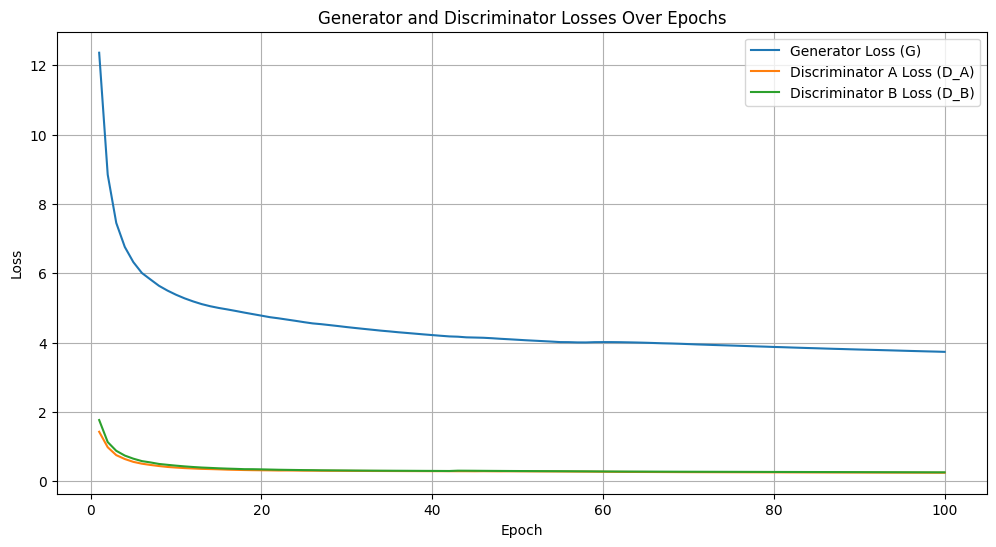

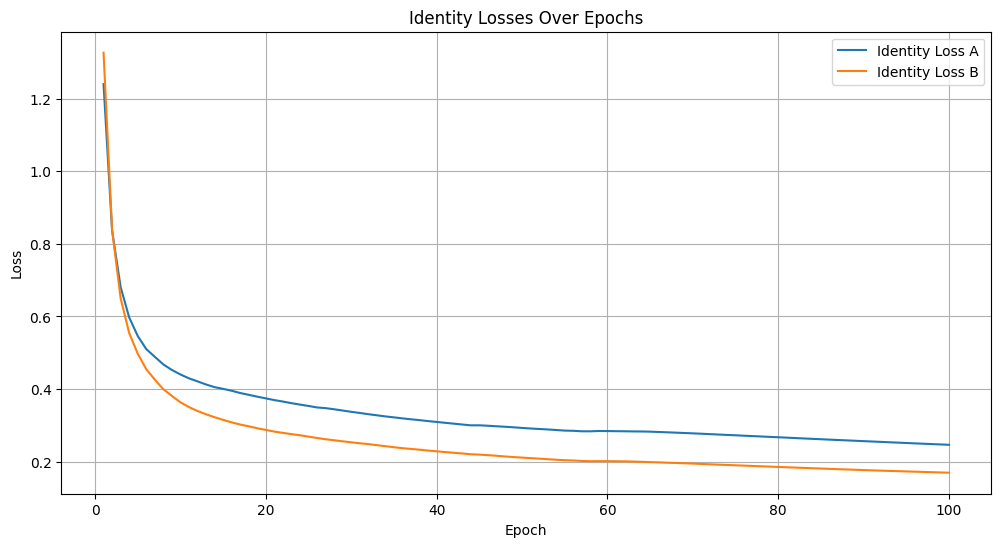

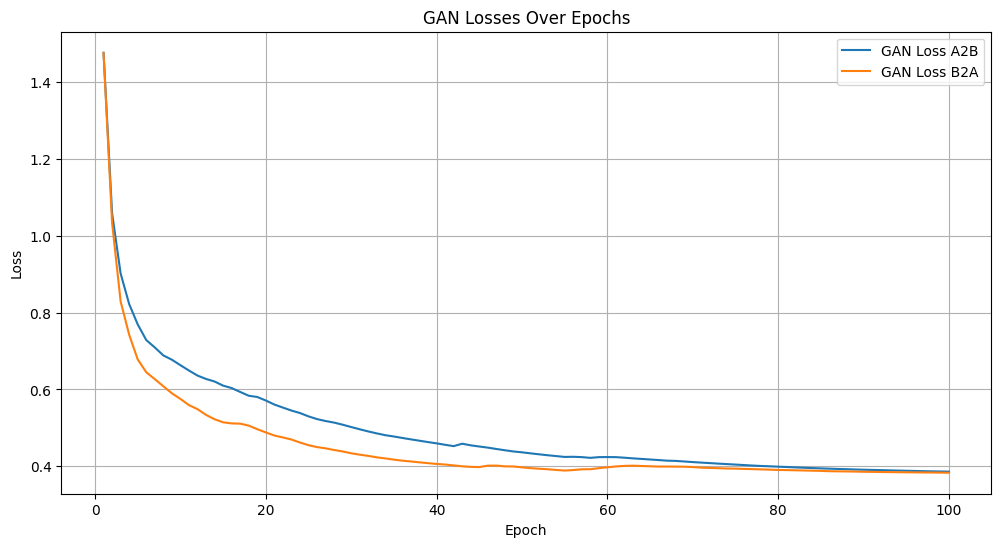

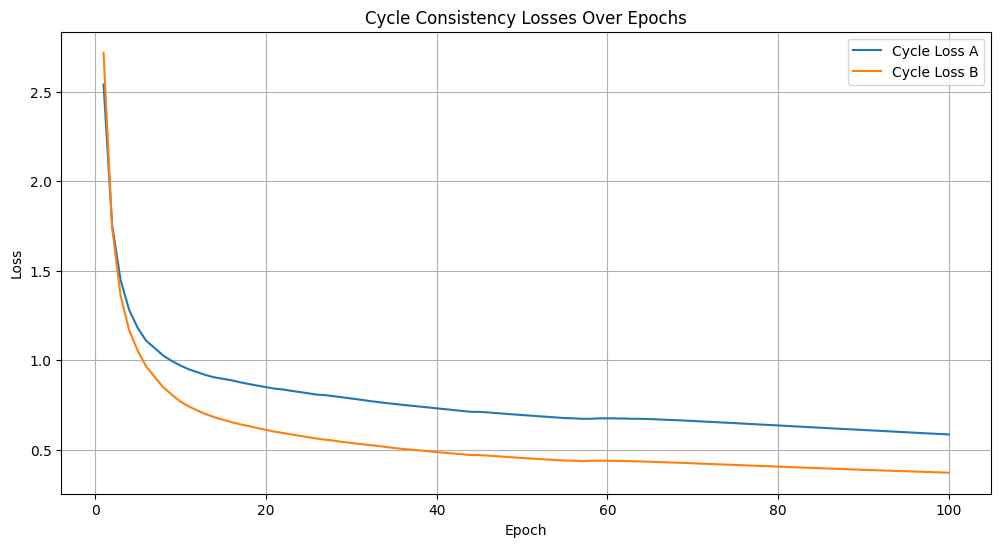

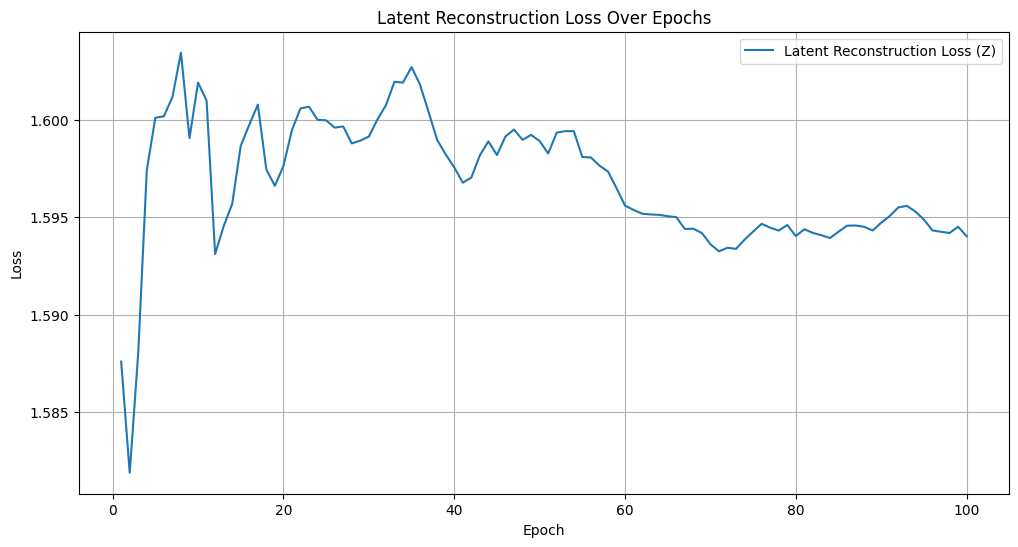

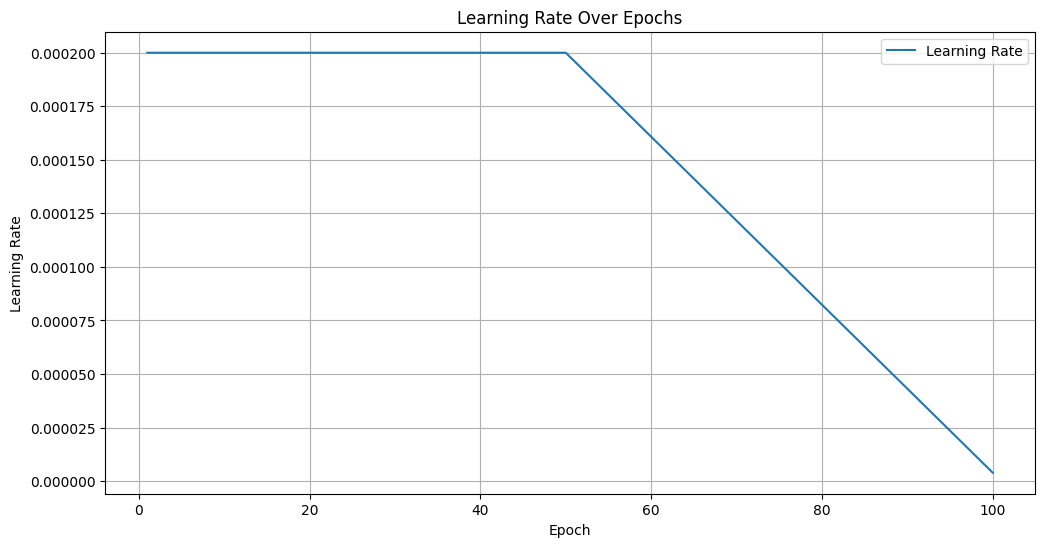

In [17]:
# %% 10) Evaluation: FID & LPIPS (approx for unpaired) - NOW ENHANCED
real_CT_folder = CT_FOLDER  
tmp_real_ct = os.path.join(OUT_DIR, 'tmp_real_CT')

final_metrics = calculate_metrics_A2B(
    generated_A2B_folder, 
    real_CT_folder, 
    tmp_real_ct,
    n_eval=min(len(os.listdir(generated_A2B_folder)), 200) # Evaluate on max 200 samples or all
)

print('Done. Check', OUT_DIR, 'for checkpoints, samples, generated images, and metrics CSVs.')
# Visualization & XAI (updated to exclude ms_ssim from plot comments) 
# Load & plot metrics
metrics_df = pd.read_csv(metrics_csv)

plt.figure(figsize=(12, 6))
plt.plot(metrics_df['epoch'], metrics_df['loss_G'], label='Generator Loss (G)')
plt.plot(metrics_df['epoch'], metrics_df['loss_D_A'], label='Discriminator A Loss (D_A)')
plt.plot(metrics_df['epoch'], metrics_df['loss_D_B'], label='Discriminator B Loss (D_B)')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Generator and Discriminator Losses Over Epochs')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(12, 6))
plt.plot(metrics_df['epoch'], metrics_df['loss_id_A'], label='Identity Loss A')
plt.plot(metrics_df['epoch'], metrics_df['loss_id_B'], label='Identity Loss B')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Identity Losses Over Epochs')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(12, 6))
plt.plot(metrics_df['epoch'], metrics_df['loss_gan_A2B'], label='GAN Loss A2B')
plt.plot(metrics_df['epoch'], metrics_df['loss_gan_B2A'], label='GAN Loss B2A')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('GAN Losses Over Epochs')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(12, 6))
plt.plot(metrics_df['epoch'], metrics_df['loss_cycle_A'], label='Cycle Loss A')
plt.plot(metrics_df['epoch'], metrics_df['loss_cycle_B'], label='Cycle Loss B')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Cycle Consistency Losses Over Epochs')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(12, 6))
plt.plot(metrics_df['epoch'], metrics_df['loss_z'], label='Latent Reconstruction Loss (Z)')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Latent Reconstruction Loss Over Epochs')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(12, 6))
plt.plot(metrics_df['epoch'], metrics_df['lr'], label='Learning Rate')
plt.xlabel('Epoch'); plt.ylabel('Learning Rate'); plt.title('Learning Rate Over Epochs')
plt.legend(); plt.grid(True); plt.show()

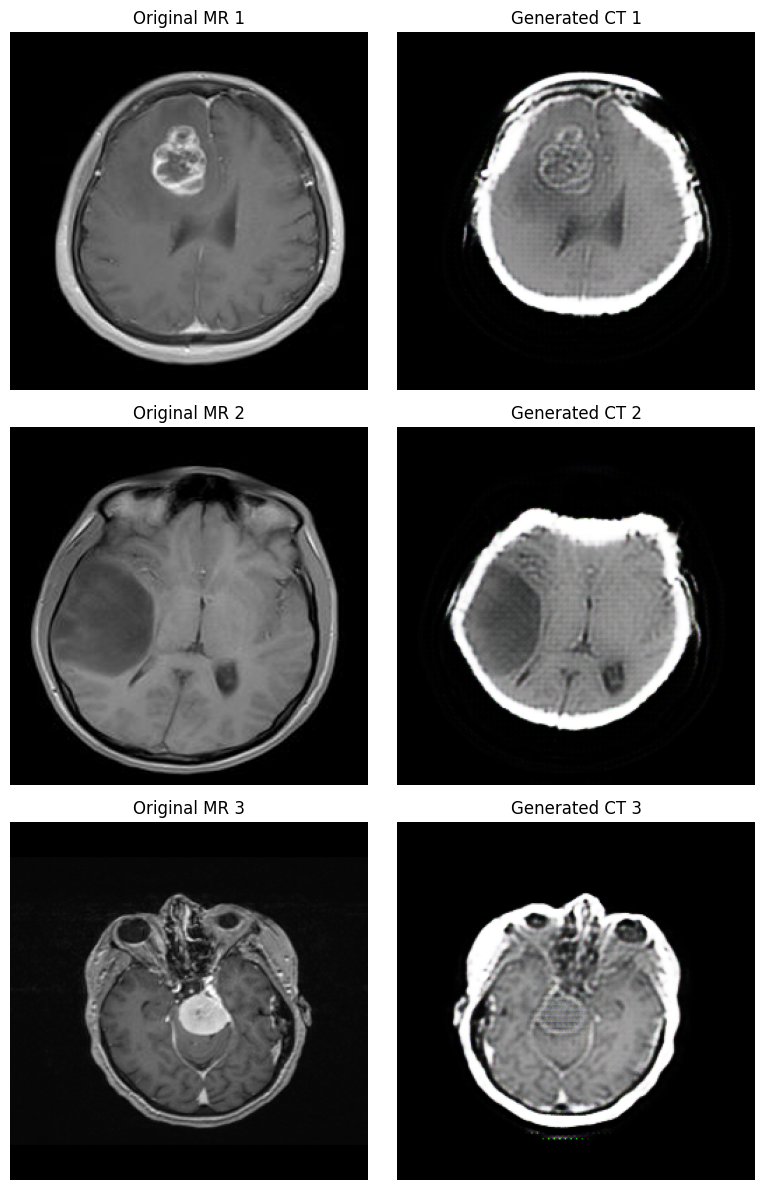

Saved sample pairs to /kaggle/working/cyclegan_outputs_augmented/plots/sample_pairs.png


In [18]:
# sample visualization (3 pairs)

gen_folder = os.path.join(OUT_DIR, 'generated_A2B')
mr_paths = sorted(glob.glob(os.path.join(MR_FOLDER, '*.dcm')))
n_show = min(3, len(mr_paths))
idxs = [0, len(mr_paths)//2, len(mr_paths)-1][:n_show]
selected = [mr_paths[i] for i in idxs]

fig, axs = plt.subplots(n_show, 2, figsize=(8, 4 * n_show))
for i, mr_p in enumerate(selected):
    mr_img = dcm_to_pil(mr_p).resize((IMAGE_SIZE, IMAGE_SIZE))
    base = os.path.basename(mr_p).replace('.dcm', '.png')
    gen_p = os.path.join(gen_folder, base)
    if not os.path.exists(gen_p):
        # maybe generation used different filename; skip if missing
        continue
    gen_img = Image.open(gen_p).convert('RGB').resize((IMAGE_SIZE, IMAGE_SIZE))
    ax_left = axs[i, 0] if n_show > 1 else axs[0]
    ax_right = axs[i, 1] if n_show > 1 else axs[1]
    ax_left.imshow(mr_img); ax_left.set_title(f'Original MR {i+1}'); ax_left.axis('off')
    ax_right.imshow(gen_img); ax_right.set_title(f'Generated CT {i+1}'); ax_right.axis('off')

plt.tight_layout()
os.makedirs(os.path.join(OUT_DIR,'plots'), exist_ok=True)
save_path = os.path.join(OUT_DIR, 'plots', 'sample_pairs.png')
plt.savefig(save_path, dpi=150)
plt.show()
plt.close()
print(f'Saved sample pairs to {save_path}')

In [19]:
# Saliency function (unchanged except using netG_A2B/netD_B explicitly)
def compute_saliency(netG, netD, netE, pil_img, transform):
    netG.eval()
    netD.eval()
    netE.eval() # Added netE eval mode
    x = transform(pil_img).unsqueeze(0).to(device)
    x.requires_grad_(True)
    # use encoder to get z_map and feed G
    with torch.no_grad():
        z = netE(x)
        z_mean = z.mean(dim=1, keepdim=True)
        z_map = z_mean.view(1,1,1,1).expand(1,1,IMAGE_SIZE,IMAGE_SIZE)
    fake = netG(torch.cat([x, z_map], dim=1))
    pred = netD(fake)
    score = pred.mean()
    netG.zero_grad()
    netD.zero_grad()
    score.backward()
    grad = x.grad.detach().cpu().squeeze()
    sal = grad.abs().max(0)[0].numpy()
    if sal.max() != sal.min():
        sal = (sal - sal.min()) / (sal.max() - sal.min())

    inp_vis = x.detach().cpu().squeeze()
    img_vis = ((inp_vis + 1.0) / 2.0).permute(1, 2, 0).numpy()
    return sal, img_vis

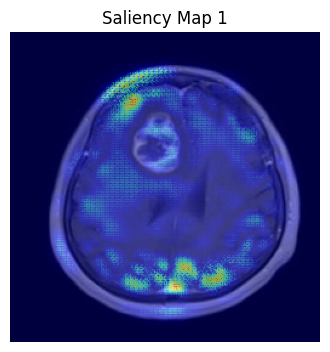

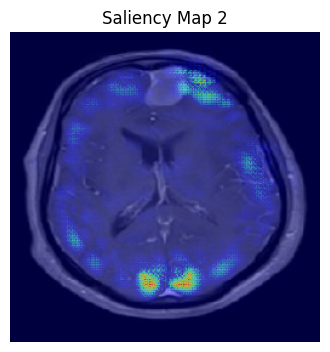

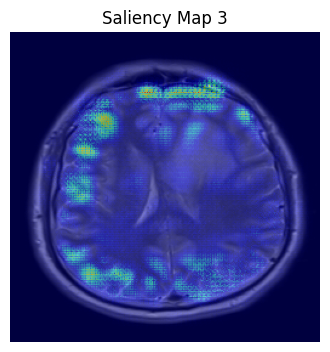

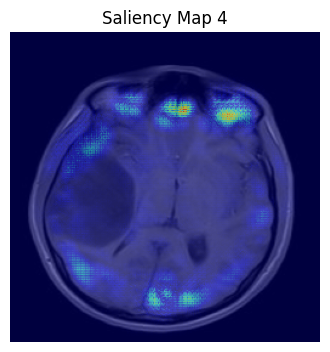

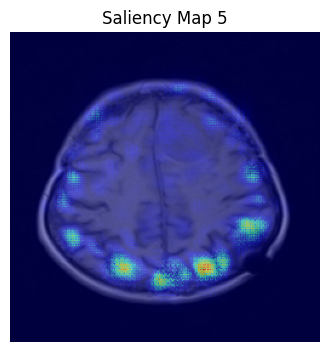

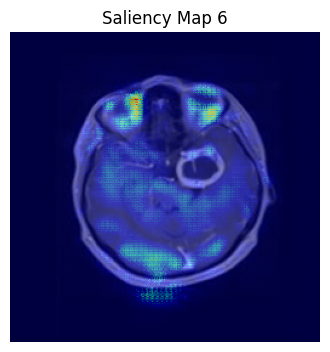

XAI Saliency maps generated and saved to /kaggle/working/cyclegan_outputs_augmented/xai
XAI Insights: Saliency highlights input regions (bright colors) that most affect the generated CT output, explaining model focus on key features like brain structures.


In [20]:
# Generate saliency for samples
xai_folder = os.path.join(OUT_DIR, 'xai')
os.makedirs(xai_folder, exist_ok=True)
mr_paths = sorted(glob.glob(os.path.join(MR_FOLDER, '*.dcm')))
if len(mr_paths) > 0:
    n_show = min(6, len(mr_paths))  # Up to 6 for more insights
    step = max(1, len(mr_paths)//n_show)
    idxs = list(range(0, len(mr_paths), step))[:n_show]
    selected = [mr_paths[i] for i in idxs]

    for i, mr_p in enumerate(selected):
        pil_img = dcm_to_pil(mr_p)
        sal, img_vis = compute_saliency(netG_A2B, netD_B, netE, pil_img, transform) # Passed netE
        plt.figure(figsize=(4, 6))
        plt.imshow(img_vis, cmap='gray')
        plt.imshow(sal, cmap='jet', alpha=0.5)
        plt.axis('off')
        plt.title(f'Saliency Map {i+1}')
        save_path = os.path.join(xai_folder, f'saliency_{i:03d}.png')
        plt.savefig(save_path, dpi=150)
        plt.show()
        plt.close()

    print(f'XAI Saliency maps generated and saved to {xai_folder}')
    print('XAI Insights: Saliency highlights input regions (bright colors) that most affect the generated CT output, explaining model focus on key features like brain structures.')
else:
    print('No MR DICOMs found for saliency generation.')

In [21]:
# ---- Grad-CAM Class ----
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        all_modules = dict([*model.named_modules()])
        if target_layer not in all_modules:
            raise ValueError(f"Target layer '{target_layer}' not found in model.")
        self.target_layer = all_modules[target_layer]
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()
        self.hook_handles.append(self.target_layer.register_forward_hook(forward_hook))
        self.hook_handles.append(self.target_layer.register_backward_hook(backward_hook))

    def remove_hooks(self):
        for h in self.hook_handles:
            h.remove()

    def __call__(self, x, class_idx=None):
        self.model.zero_grad()
        output = self.model(x)
        score = output.mean() if class_idx is None else output[:, class_idx].mean()
        score.backward()

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = cam.squeeze().cpu().numpy()
        if cam.max() - cam.min() > 1e-6:
            cam = (cam - cam.min()) / (cam.max() - cam.min())
        else:
            cam = np.zeros_like(cam)
        return cam

In [22]:
# ---- Overlay + Show Utility ----
def overlay_heatmap_and_show(img_tensor, heatmap, save_path, title=None):
    img = img_tensor.squeeze().detach().cpu().numpy().transpose(1, 2, 0)
    img_vis = (((img + 1.0) / 2.0) * 255).astype(np.uint8)

    if img_vis.ndim == 2:
        img_vis = cv2.cvtColor(img_vis, cv2.COLOR_GRAY2BGR)
    elif img_vis.shape[2] == 3:
        img_vis = cv2.cvtColor(img_vis, cv2.COLOR_RGB2BGR)

    heatmap_resized = cv2.resize(heatmap, (img_vis.shape[1], img_vis.shape[0]))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img_vis, 0.6, heatmap_color, 0.4, 0)

    # Save to disk
    cv2.imwrite(save_path, overlay)

    # Show inline
    plt.figure(figsize=(5, 5))
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.title(title if title else "Grad-CAM Overlay")
    plt.axis('off')
    plt.show()

Generating Grad-CAM for 6 samples...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


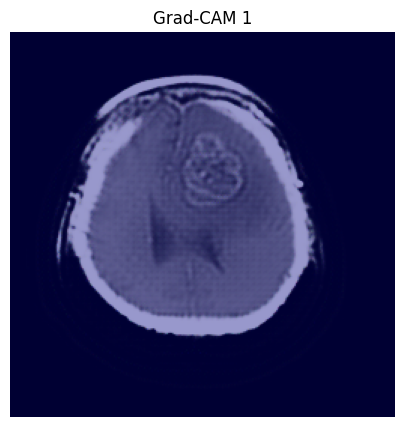

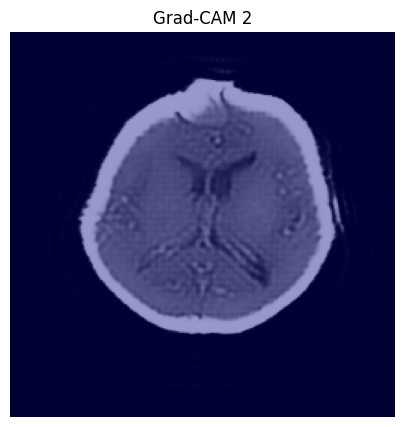

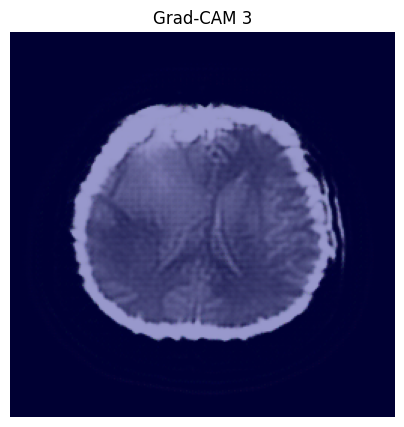

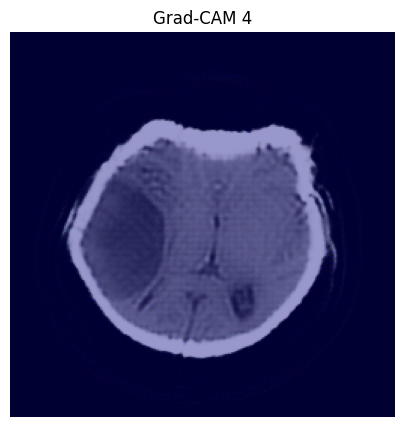

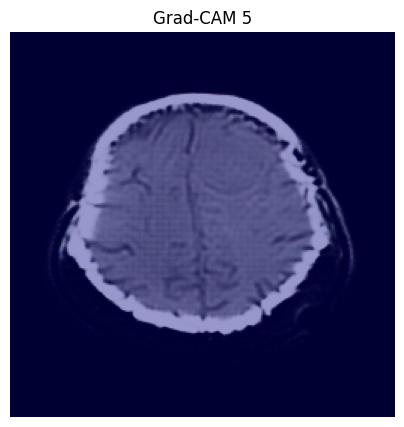

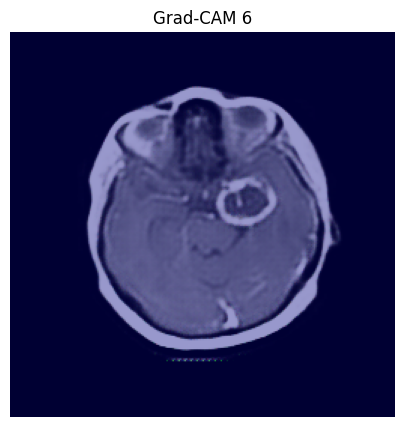

 Grad-CAM visualizations saved in /kaggle/working/cyclegan_outputs_augmented/xai_gradcam


In [23]:
# ---- Run Grad-CAM on 6 Samples ----
os.makedirs(os.path.join(OUT_DIR, "xai_gradcam"), exist_ok=True)

netG_A2B.eval(); netD_B.eval(); netE.eval()

try:
    gradcam = GradCAM(netD_B, target_layer='model.7')
except ValueError as e:
    print(f"Skipping Grad-CAM: {e}")
else:
    # Select 6 evenly spaced samples from dataset
    n_samples = min(6, len(dataset))
    step = max(1, len(dataset) // n_samples)
    idxs = list(range(0, len(dataset), step))[:n_samples]

    print(f"Generating Grad-CAM for {n_samples} samples...")

    for i, idx in enumerate(idxs):
        sample = dataset[idx]
        sample_A = sample["A"].unsqueeze(0).to(device)

        with torch.no_grad():
            z = netE(sample_A)
            z_map = z.mean(dim=1, keepdim=True).view(1, 1, 1, 1).expand(1, 1, IMAGE_SIZE, IMAGE_SIZE)
            fake_translated = netG_A2B(torch.cat([sample_A, z_map], dim=1))
        cam_map = gradcam(fake_translated)

        save_path = os.path.join(OUT_DIR, "xai_gradcam", f"gradcam_fake_{i+1}.png")
        overlay_heatmap_and_show(fake_translated, cam_map, save_path, title=f"Grad-CAM {i+1}")

    gradcam.remove_hooks()
    print(f" Grad-CAM visualizations saved in {os.path.join(OUT_DIR, 'xai_gradcam')}")

In [24]:
def visualize_feature_maps(netG_A2B, netE, real_A, device, num_samples=3, layer_index=0, save_dir='feature_maps'):
    """
    Visualize intermediate feature maps for the generator (ResnetGenerator) using correct 4-channel input.
    Displays the input image first, followed by selected feature maps.
    """
    
    os.makedirs(save_dir, exist_ok=True)
    activation = {}

    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    # Hook into target layer of ResnetGenerator
    layer = netG_A2B.model[layer_index]
    hook_handle = layer.register_forward_hook(get_activation(f'layer_{layer_index}'))

    # Generate latent map (z_map)
    with torch.no_grad():
        # Ensure the entire batch is on the correct device for encoder
        z = netE(real_A.to(device))
        z_mean = z.mean(dim=1, keepdim=True)
        z_map = z_mean.view(z_mean.size(0), 1, 1, 1).expand(-1, 1, real_A.size(2), real_A.size(3))

    # ---- Visualize for 3 samples ----
    for i in range(min(num_samples, real_A.size(0))):
        img = real_A[i].unsqueeze(0).to(device)
        z_sample = z_map[i].unsqueeze(0)
        G_input = torch.cat([img, z_sample], dim=1)  # 4-channel input

        _ = netG_A2B(G_input)  # forward pass triggers hook

        fmap = activation[f'layer_{layer_index}'].cpu().squeeze(0)  # (C,H,W)
        num_channels = fmap.shape[0]

        # Determine how many images to show: 1 Input + 4 Feature Maps
        n_show_maps = min(4, num_channels)
        total_cols = 1 + n_show_maps

        fig, axes = plt.subplots(1, total_cols, figsize=(3 * total_cols, 4))
        fig.suptitle(f"Feature Maps - Sample {i+1} (Layer {layer_index})", fontsize=13)

        # 1. Plot Input Image (at index 0)
        # Convert [-1, 1] tensor to [0, 1] numpy for visualization
        input_vis = ((img.cpu().squeeze().permute(1, 2, 0).numpy() + 1.0) / 2.0).clip(0, 1)
        
        axes[0].imshow(input_vis)
        axes[0].set_title('Input Image')
        axes[0].axis('off')

        # 2. Plot Feature Maps (starting at index 1)
        for j in range(n_show_maps):
            axes[j + 1].imshow(fmap[j], cmap='viridis')
            axes[j + 1].set_title(f"Map {j+1}")
            axes[j + 1].axis('off')

        plt.tight_layout()
        plt.subplots_adjust(top=0.85)
        plt.show()

        save_path = os.path.join(save_dir, f"sample_{i+1}_layer_{layer_index}.png")
        fig.savefig(save_path)
        plt.close(fig)

    hook_handle.remove()
    print(f"Feature maps (layer {layer_index}) saved in: {save_dir}")

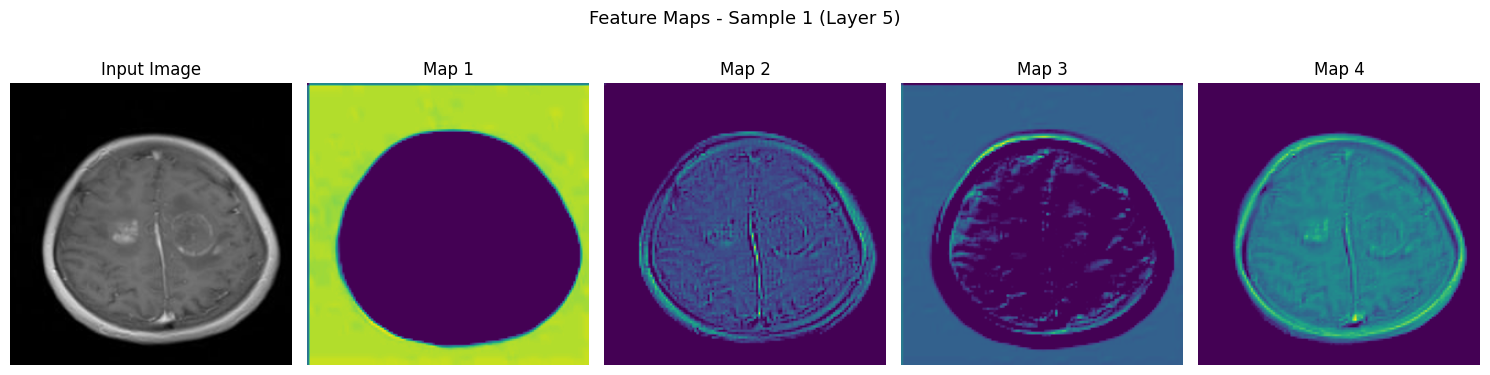

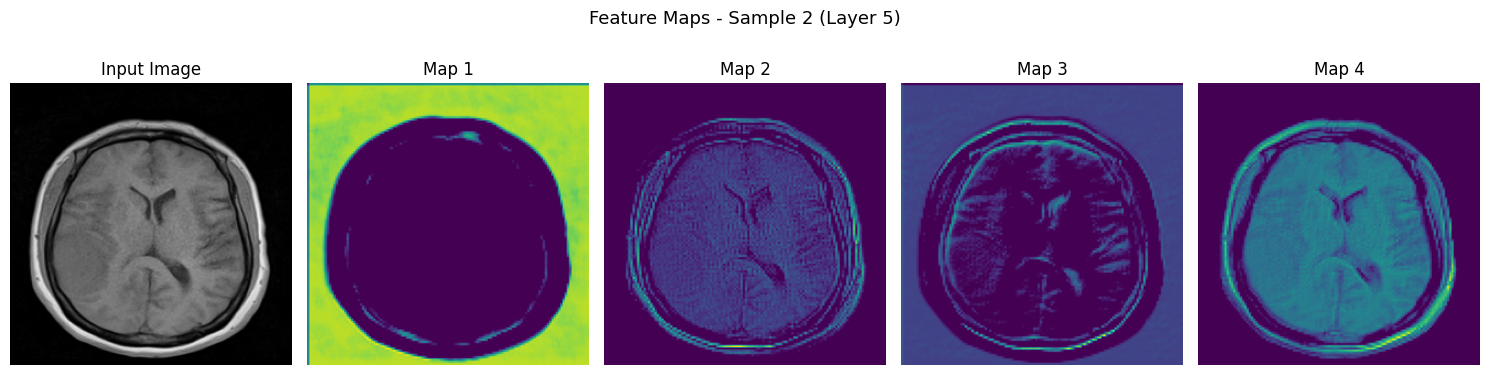

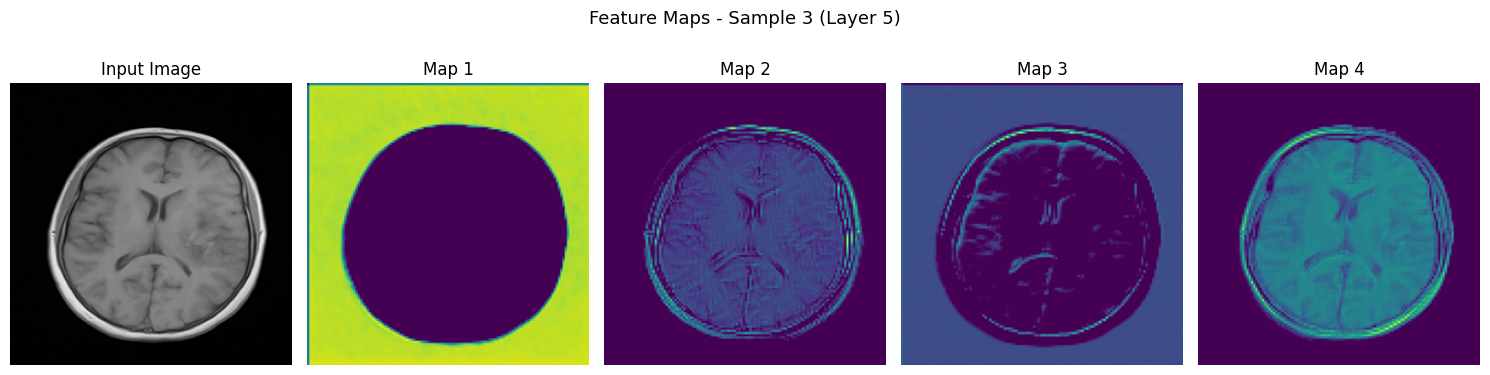

Feature maps (layer 5) saved in: feature_maps


In [25]:
# The example call remains the same, assuming netG_A2B, netE, real_A, and device are defined.
# Example: visualize feature maps from middle layer (say layer 5)
visualize_feature_maps(netG_A2B, netE, real_A, device, num_samples=3, layer_index=5)